# BranchPro: inference of R_t

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd

num_timepoints = 30 # number of days for incidence data

# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
m = branchpro.BranchProModel(initial_r, serial_interval)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   66.   92.  118.  183.  247.  333.  425.  645.  870. 1201.
 1704. 2356. 3244. 4580.  978. 1462. 1374. 1172.  906.  758.  671.  522.
  461.  381.  328.  261.  232.  196.]


In [2]:
# Posterior of R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

# print(len(serial_interval))
# print(len(cases))

i=0
for t in range(R_t_start,num_timepoints+1):
#     print(t)
    shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
    sum_var = 0
    for k in range(t-tau,t+1):
        vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
        vec2 = serial_interval[:k] # w_1, ... , w_k
        
#         print(len(vec1))
#         print(len(vec2))
#         print(np.multiply(vec1,vec2))
        sum_var += math.fsum( np.multiply(vec1,vec2) )
    rate.append( 1/b + sum_var )
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape,scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)

# print(shape)
# print(rate)
# print(mean)


Text(0.5, 1.0, 'Inferred effective reproduction number vs. time')

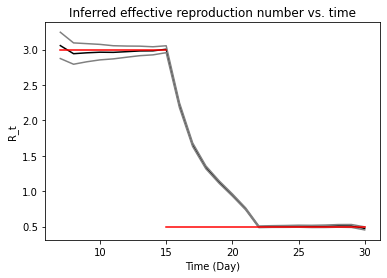

In [3]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1], num_timepoints+1))

fig = plt.figure()
plt.plot(np.arange(R_t_start,num_timepoints+1), mean, 'k')
plt.plot(np.arange(R_t_start,num_timepoints+1), post_dist_interval[0], 'gray')
plt.plot(np.arange(R_t_start,num_timepoints+1), post_dist_interval[1], 'gray')
plt.plot(np.arange(R_t_start, start_times[1]+1), L1*[3], 'red')
plt.plot(np.arange(start_times[1], num_timepoints+1), L2*[0.5], 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')

In [5]:
# Same inference, but using the BranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

Text(0.5, 1.0, 'Inferred effective reproduction number vs. time')

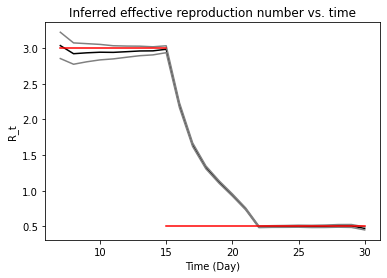

In [7]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1], num_timepoints+1))

fig = plt.figure()
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Mean'], 'k')
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Lower bound CI'], 'gray')
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Upper bound CI'], 'gray')
plt.plot(np.arange(R_t_start, start_times[1]+1), L1*[3], 'red')
plt.plot(np.arange(start_times[1], num_timepoints+1), L2*[0.5], 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')